## **To recreate study results please load package versions found in main_requirements.txt**

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
import math
import seaborn as sns
import os
# %config IPCompleter.greedy=True
%load_ext autoreload
%autoreload 2

sc.settings.verbosity = 0
sc.logging.print_header()
sns.set_context("paper")

scanpy==1.10.3 anndata==0.10.9 umap==0.5.7 numpy==1.26.4 scipy==1.13.1 pandas==2.2.3 scikit-learn==1.6.1 statsmodels==0.14.4 igraph==0.8.3 pynndescent==0.5.13


In [2]:
import warnings
warnings.simplefilter( action="ignore", category=FutureWarning)

In [3]:
# import local module containing misc code, helps keep notebooks clean from commonly used functions
import new_misc_code as nmc 

In [4]:
# set paths to directories for data and figures
fig_path = "/dd_userdata/usrdat03/userdata/cherring/data/cellranger_outputs/brain_maturation_RNA/out_figs/"

In [5]:
# read in count matrices post nuclei and gene quality control
adata = sc.read( "../data/cleaned_count_matrices.h5ad")
adata

AnnData object with n_obs × n_vars = 175954 × 29030
    obs: 'batch', 'RL#', 'age', 'chem', 'concat_id', 'numerical_age', 'stage_id', 'Sex', 'Race', 'PMI', 'Brain Regions*', 'Cause of Death', 'ICD-10 Code', 'ICD-10 category', 'Oxygen/No Oxygen', 'Date-of-Collection', 'Collection_year', 'Library Prep Date', 'Library Prep Lot', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'doublet_score', 'log10_gene_counts', 'log10_UMI_counts', 'percent_mito', 'percent_ribo'
    var: 'gene_ids', 'feature_types', 'non-unique_names', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts'
    uns: 'age_order', 'batch_colors', 'batch_colors_dict', 'batch_order', 'stage_colors_dict', 'stage_id_colors', 'stage_order'

## **Batch correct by downsampling each nuclei's counts to a standardized library size**

In [6]:
# save raw current count matrix to raw
adata.layers['raw-cts_pre-ds'] = adata.X.copy()

In [7]:
## I am not sure if its a feature or a bug but sc.pp.filter_genes will produce equal in shape 
## but different csr matrices, if anndata is copied or not.
## I have copied here to make results in manuscript more reproducible with orginal 
## analysis that must have had an unknown copy made prior to filtering genes.
adata = adata[:]

In [8]:
# only want to sample from genes that would pass preprocessing without downsampling
sc.pp.filter_genes( adata, min_cells=5)
adata.shape

Trying to set attribute `.var` of view, copying.


(175954, 28954)

In [9]:
# standardize library sizes by removing nucs with low libs and downsampling the rest
def standardize_libs( adata, tar_lib_sz=1_000, seed=123):
    # make sure counts for each nuc are current
    sc.pp.calculate_qc_metrics( adata, percent_top=None, inplace=True)
    # print number of nucs to be removed
    print( "Number of low lib nucs removed per run:")
    low_mask = ( adata.obs['total_counts']<=tar_lib_sz)
    print( pd.value_counts( adata.obs.batch.values[low_mask]).to_string())
    
    # remove nucs with low library sizes
    #### comment out line below to keep low UMI count nuclei ####
    sc.pp.filter_cells( adata, min_counts=tar_lib_sz, copy=False)
    
    # downsample nuc total counts over target library size
    sc.pp.downsample_counts( adata, counts_per_cell=tar_lib_sz, copy=False, replace=False, random_state=seed)
    # due to scanpy bug in this version have to reset dtype
    adata.X = adata.X.astype( float)
    return

In [10]:
standardize_libs( adata)

Number of low lib nucs removed per run:
RL2109_4yr_v3     3523
RL1614_8yr_v2     1487
RL1613_2yr_v2     1483
RL2104_118d_v3    1443
RL2102_16yr_v3    1374
RL2123_20yr_v3    1307
RL2129_3yr_v3     1148
RL2131_17yr_v3     950
RL2106_6yr_v3      934
RL2124_40yr_v3     755
RL2100_86d_v3      699
RL2122_301d_v3     680
RL2105_627d_v3     650
RL2108_179d_v3     635
RL1612_34d_v2      622
RL2121_ga34_v3     530
RL2127_12yr_v3     521
RL2132_25yr_v3     494
RL2128_20yr_v3     470
RL2103_ga22_v3     385
RL2126_10yr_v3     332
RL2107_ga24_v3     181
RL2130_14yr_v3     159
RL2110_10yr_v3     151
RL2125_422d_v3     147
RL1777_2d_v3       135
RL1786_2yr_v3       37


In [11]:
adata.shape

(154748, 28954)

In [12]:
# filter genes post downsampling
sc.pp.filter_genes( adata, min_cells=5)

In [13]:
adata.shape #, samples.adata.shape

(154748, 26747)

Nuclei count per batch

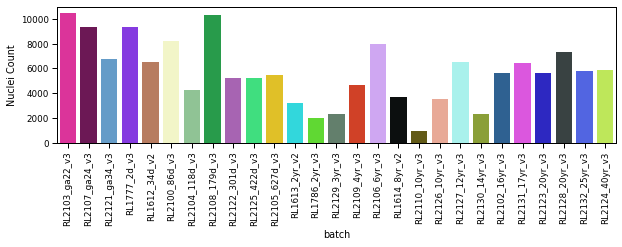

In [14]:
plt.figure( figsize=(10,2.5))
plt.xticks(rotation=90) 
sns.countplot( adata.obs['batch'], order=adata.uns['batch_order'], palette=adata.uns['batch_colors_dict'], );
plt.ylabel( "Nuclei Count");
plt.savefig( f"{fig_path}whole-tissue_post-ds_nuc-cts_per-batch.svg", format='svg', bbox_inches='tight')

Nuclei count per stage_id

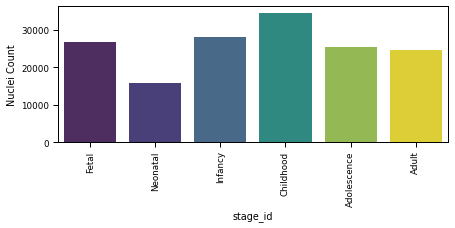

In [15]:
plt.figure( figsize=(7,2.5))
plt.xticks(rotation=90) 
sns.countplot( adata.obs['stage_id'], order=adata.uns['stage_order'], palette=adata.uns['stage_colors_dict'], );
plt.ylabel( "Nuclei Count");
plt.savefig( f"{fig_path}whole-tissue_post-ds_nuc-cts_per-stage.svg", format='svg', bbox_inches='tight')

### Normalize (with standard library size, just scaling data) and scale to CPM 

In [16]:
# re-calculate umi and gene counts per nuclei
sc.pp.calculate_qc_metrics( adata, percent_top=None, inplace=True)
# scale to CPM
sc.pp.normalize_total( adata, target_sum=1e6, inplace=True)

### Variance Stabilizing Transformation - VST

In [17]:
sc.pp.log1p( adata, copy=False)

### Feature Selection - select 5,000 highly variable genes

In [4]:
n_hvg = 5_000
sc.pp.highly_variable_genes( adata, n_top_genes=n_hvg, n_bins=20, flavor='seurat', inplace=True)
sc.pl.highly_variable_genes( adata)

NameError: name 'adata' is not defined

In [19]:
high_adata = adata[:,adata.var.highly_variable.values]
high_adata.shape

(154748, 4999)

## **PCA**

In [20]:
n_comps = 375
sc.pp.pca( high_adata, n_comps=n_comps) #, use_highly_variable=True)

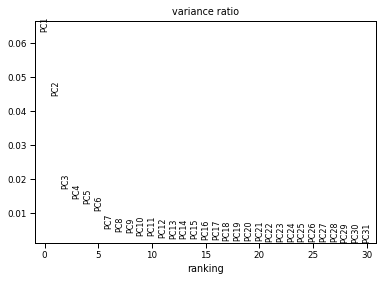

In [21]:
sc.pl.pca_variance_ratio( high_adata)

Find number of components needed to explain 50% of variation in data

In [22]:
n_pcs = ( np.cumsum( high_adata.uns['pca']['variance_ratio'])<0.50).sum()
if( n_pcs==n_comps):
    n_pcs = None
    print( "re-run PCA with more components")
n_pcs

365

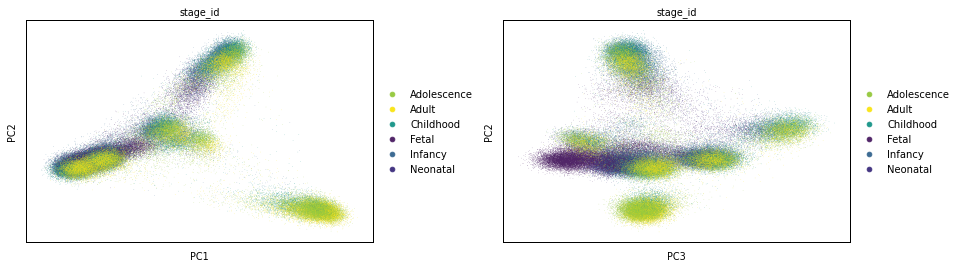

In [23]:
sc.pl.pca( high_adata, color=['stage_id'], components=['1,2','3,2'], legend_fontsize=10, wspace=0.25)

## **UMAP**

In [24]:
# set number of cores to use
sc.settings.n_jobs = 25
# find nearest neighbors
sc.pp.neighbors( high_adata, n_neighbors=25, n_pcs=n_pcs, random_state=6)
# calc umap
sc.tl.umap( high_adata, random_state=6)

## **Leiden Clusting**
This is clustering for all nuclei, but inhibitory neurons separately are re-clustered at a higher resolution in the inhibitory_clustering.ipynb notebook. 

In [25]:
# Clustering may take a bit to run, ~7mins on 30 cores
sc.tl.leiden( high_adata, resolution=7, random_state=123)
sc.tl.rank_genes_groups( high_adata, 'leiden')

## **Misc Feature Plots**

Since scanpy doesn't currently have an option to fully randomize order of observations for plotting, create a randomly ordered adata for plotting. Setting *sort_order=False* will still plot observations in order of indices, i.e. order batches were concated. 

In [26]:
# subsampling the full adata will reproduce adata with random order
plt_adata = sc.pp.subsample( high_adata, fraction=1.0, random_state=0, copy=True)

/scratchfs/cherring/brain_maturation/bm_project_env/main_bm/lib/python3.7/site-packages/scanpy/_settings.py:446: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


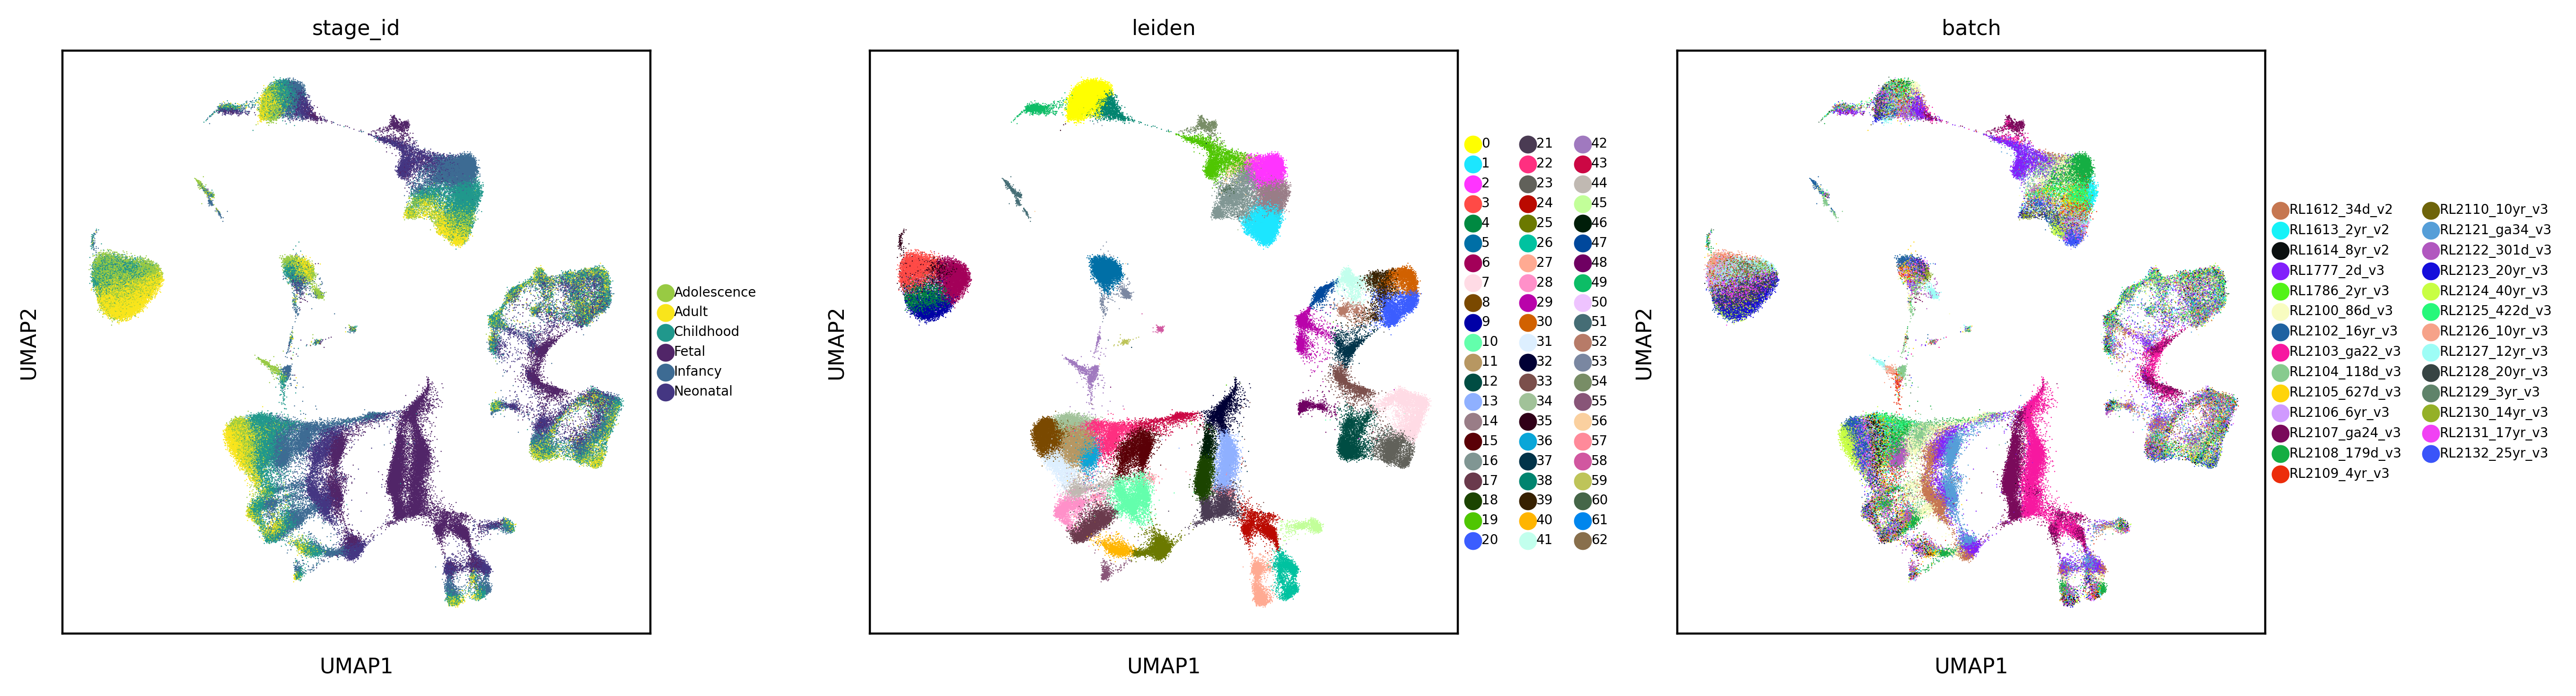

In [27]:
sc.settings.set_figure_params( dpi=200, fontsize=8)
sc.pl.umap( plt_adata, color=['stage_id','leiden','batch'], legend_fontsize=5, wspace=0.25)
# sc.pl.umap( plt_adata, color=['stage_id','batch'], legend_fontsize=5, wspace=0.25)

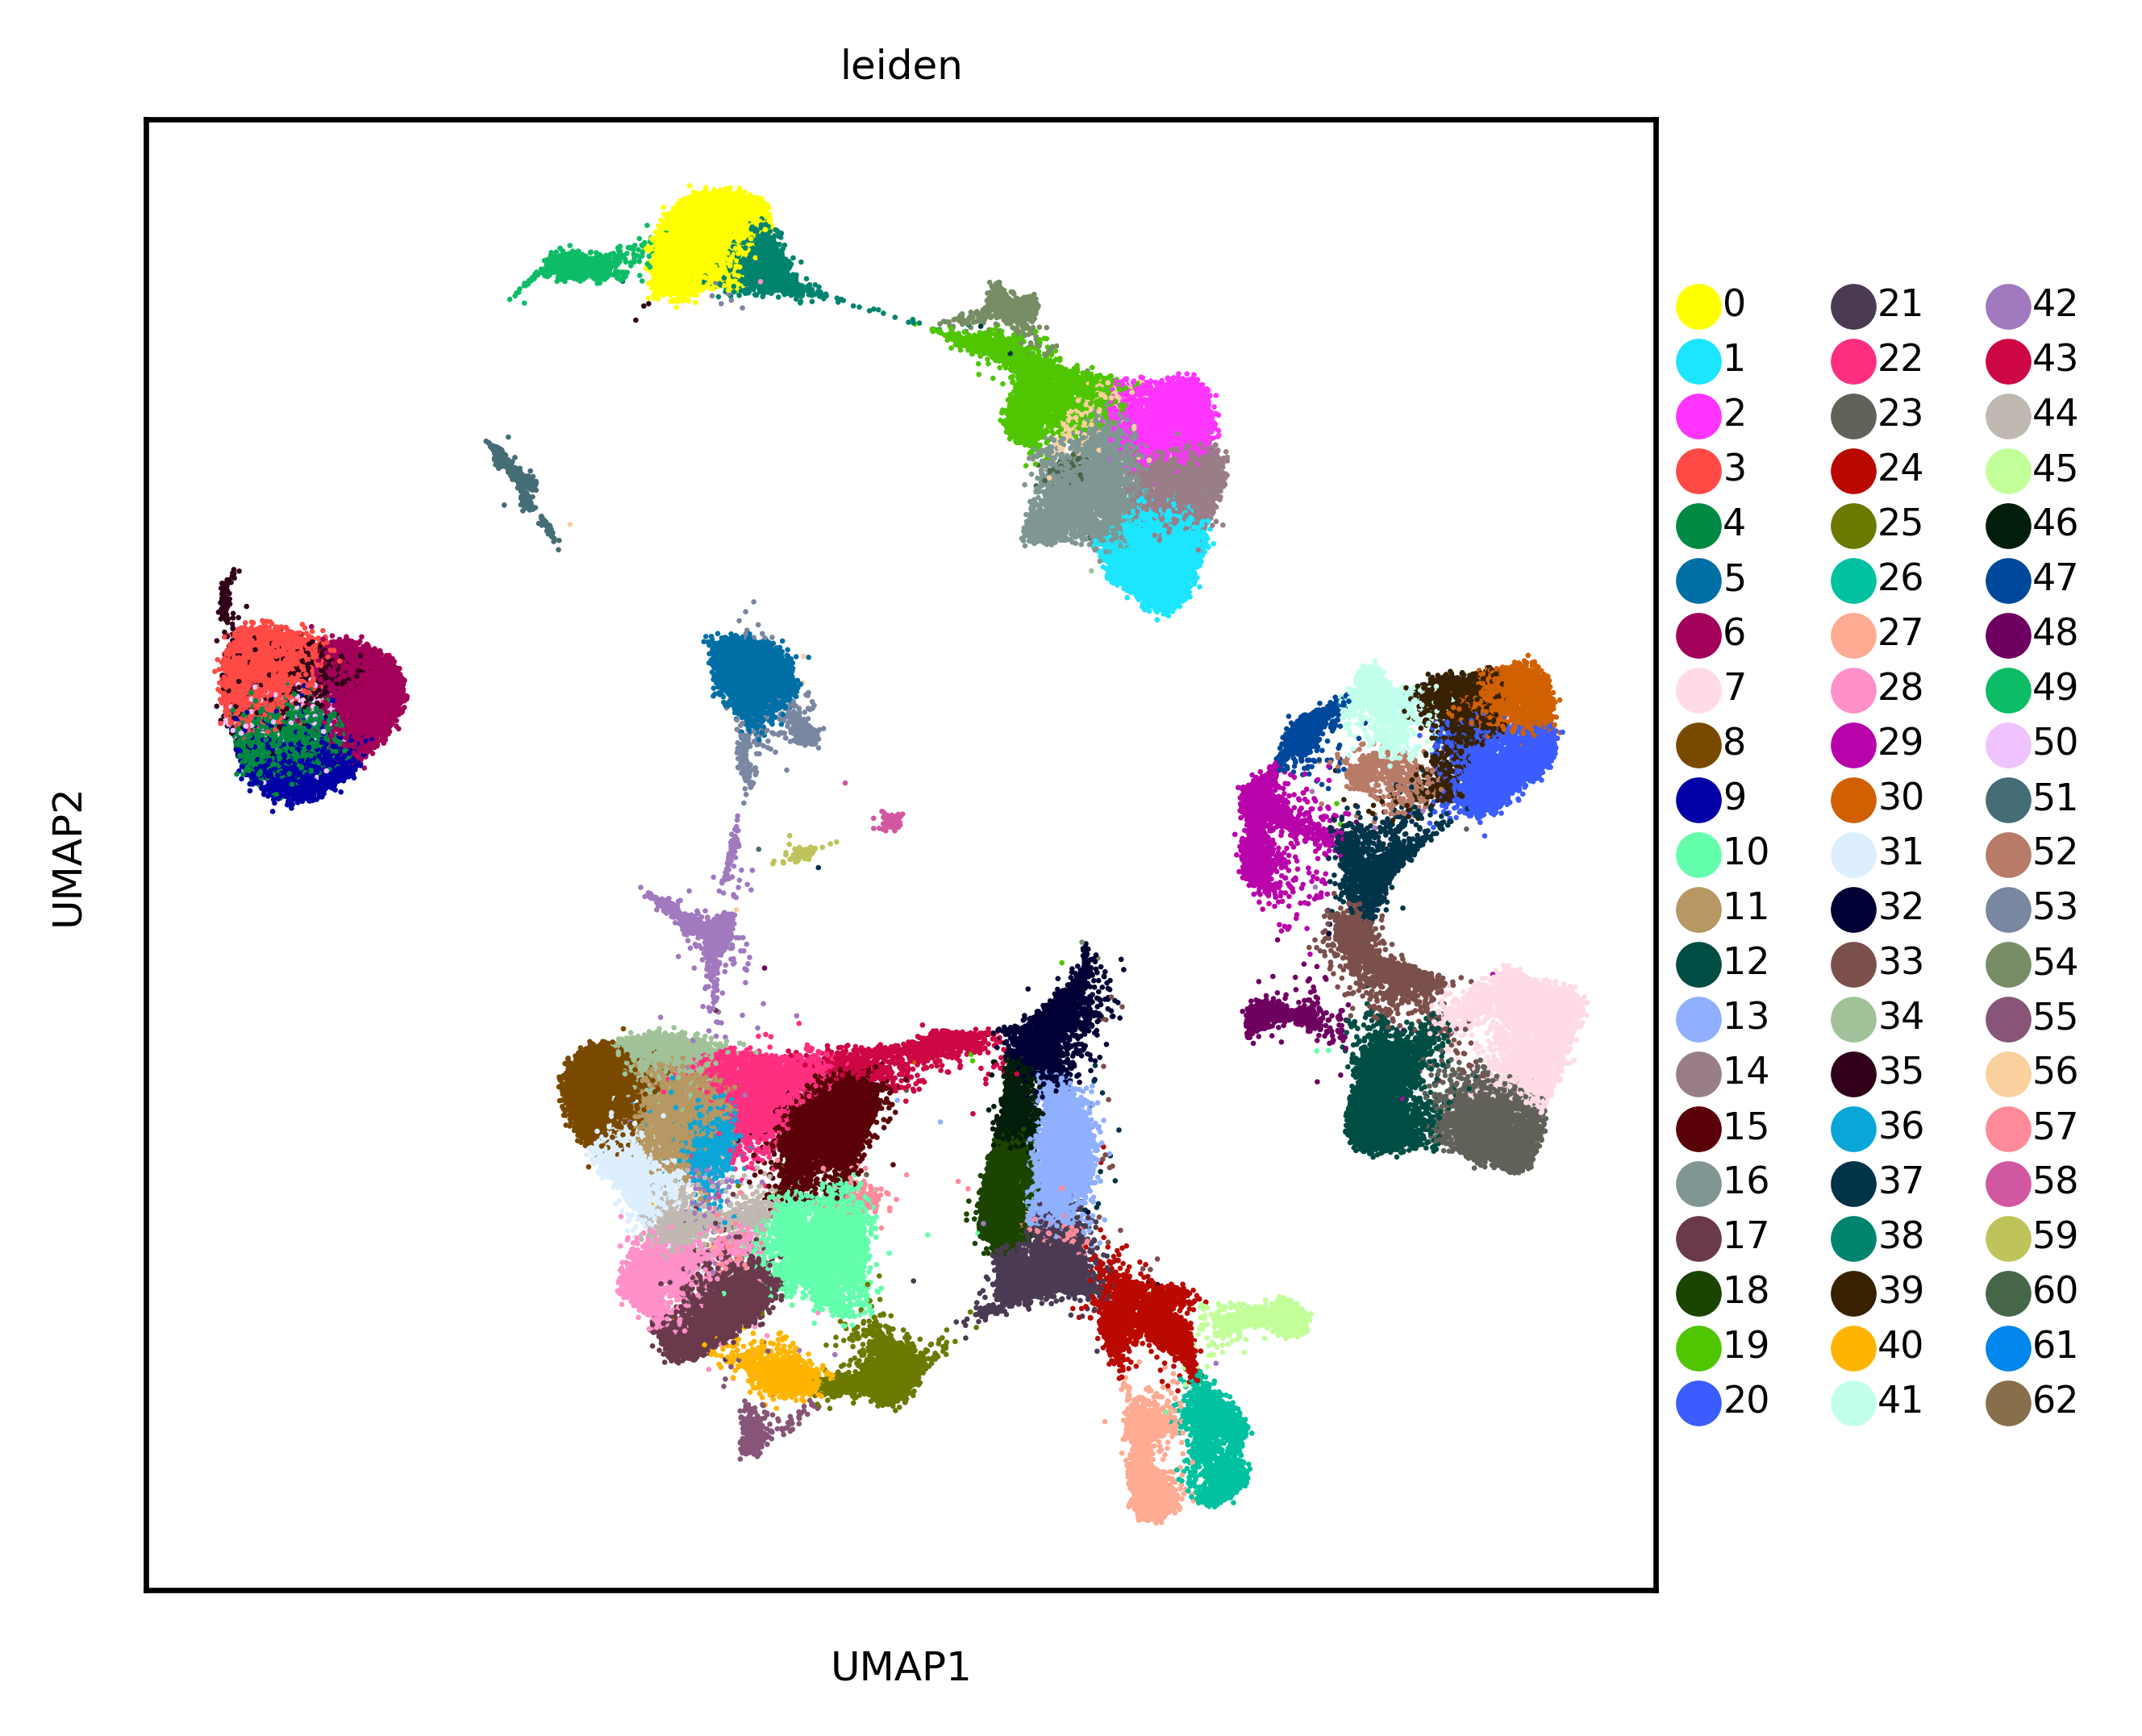

In [28]:
# settings for manuscript plots
feat = 'leiden'
sc.settings.set_figure_params( dpi=300, fontsize=6)
ax = sc.pl.umap( plt_adata, color=feat, size=2.5, sort_order=False, show=False)
plt.savefig( f"{fig_path}whole-tissue_UMAP-{feat}.png", format='png', dpi=300, bbox_inches='tight')

## **Gene Overlay Plots - with full count matrix**

In [29]:
# set umap and pca to adata
adata.obsm = high_adata.obsm
# set connectivities and distances from umap to adata
adata.obsp = high_adata.obsp
# set clustering to adata
adata.obs['leiden'] = high_adata.obs['leiden']
# set downsampled count data to layer
adata.layers['ds_norm_cts'] = adata.X.copy()
# normalize full count matrix for overlays
adata.X = adata.layers['raw-cts_pre-ds'].copy()
# re-calculate umi and gene counts per nuclei
sc.pp.calculate_qc_metrics( adata, percent_top=None, inplace=True)
# scale to CPM
sc.pp.normalize_total( adata, target_sum=1e6, inplace=True)
# VST
sc.pp.log1p( adata, copy=False)
# randomize order again
plt_adata = sc.pp.subsample( adata, fraction=1.0, random_state=0, copy=True) 

In [30]:
sc.settings.set_figure_params( dpi=150, fontsize=6)
def plot_save_overlays( genes, title, adata=plt_adata, pt_size=5):
    ax = sc.pl.umap( adata, color=genes, size=pt_size, sort_order=False, cmap='magma', show=False)
    plt.savefig( f"{fig_path}whole-tissue_UMAP-{title}.png", format='png', bbox_inches='tight')
    return

/scratchfs/cherring/brain_maturation/bm_project_env/main_bm/lib/python3.7/site-packages/scanpy/_settings.py:446: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


Principle Neuron Markers

/scratchfs/cherring/brain_maturation/bm_project_env/main_bm/lib/python3.7/site-packages/scanpy/plotting/_tools/scatterplots.py:999: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  pl.colorbar(cax, ax=ax, pad=0.01, fraction=0.08, aspect=30)


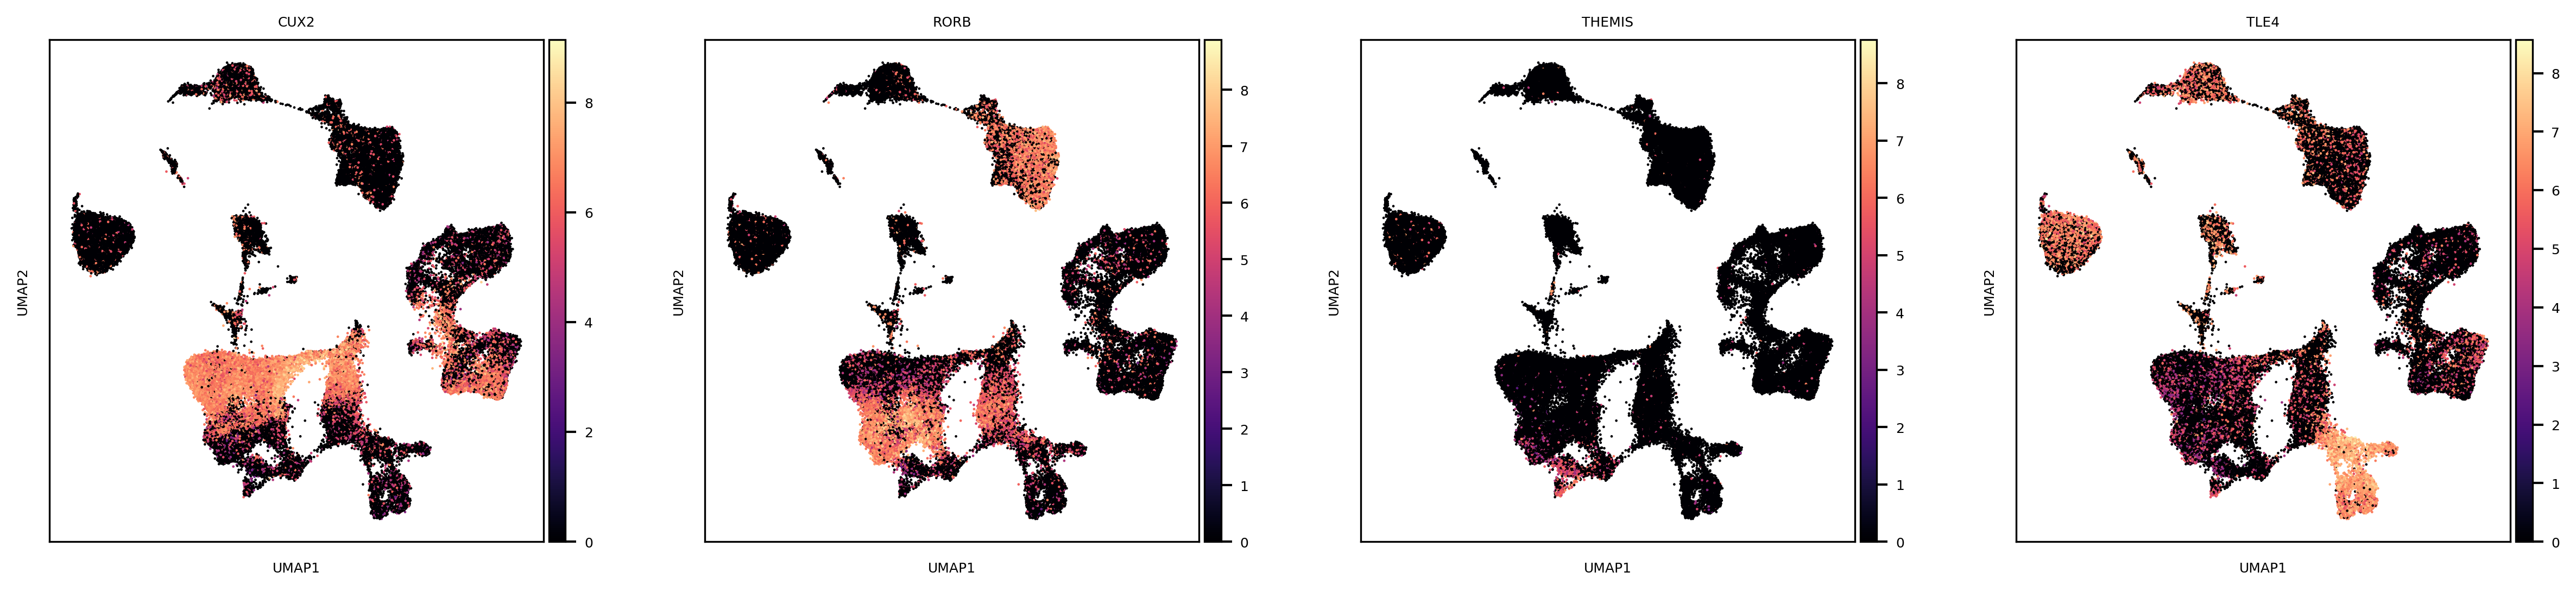

In [31]:
pn_genes = ['CUX2','RORB','THEMIS','TLE4']
plot_save_overlays( pn_genes, 'PN_genes')

Inhibitory Neruon Markers

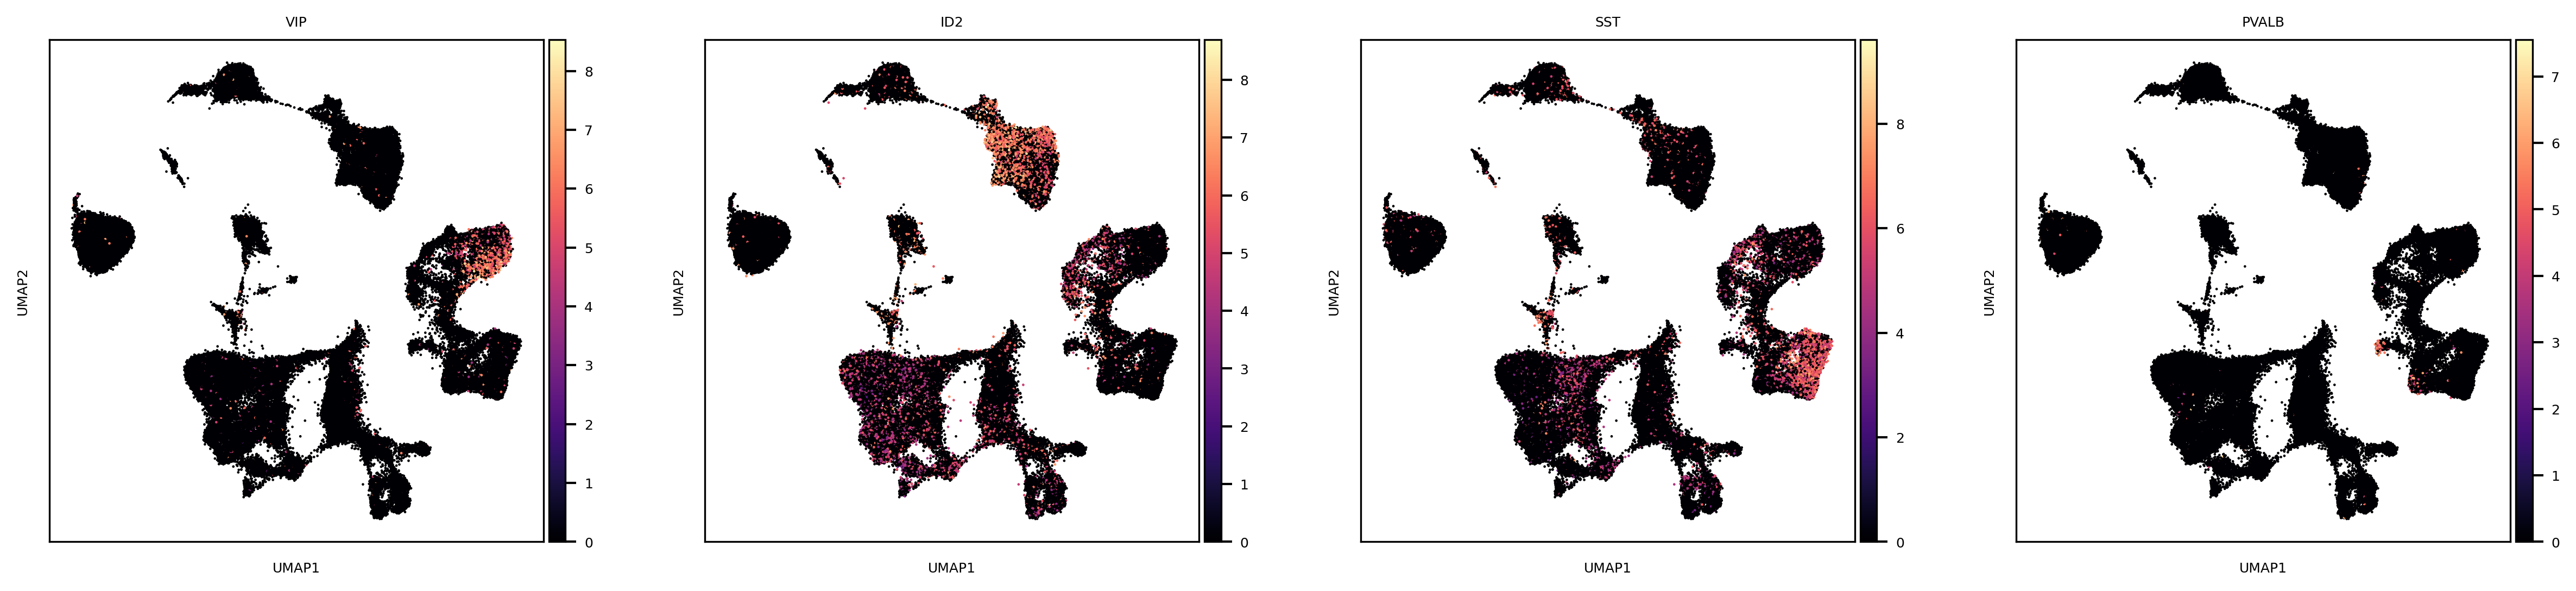

In [32]:
in_genes = ['VIP','ID2','SST','PVALB']
plot_save_overlays( in_genes, 'IN_genes')

Glia and Vascular Markers

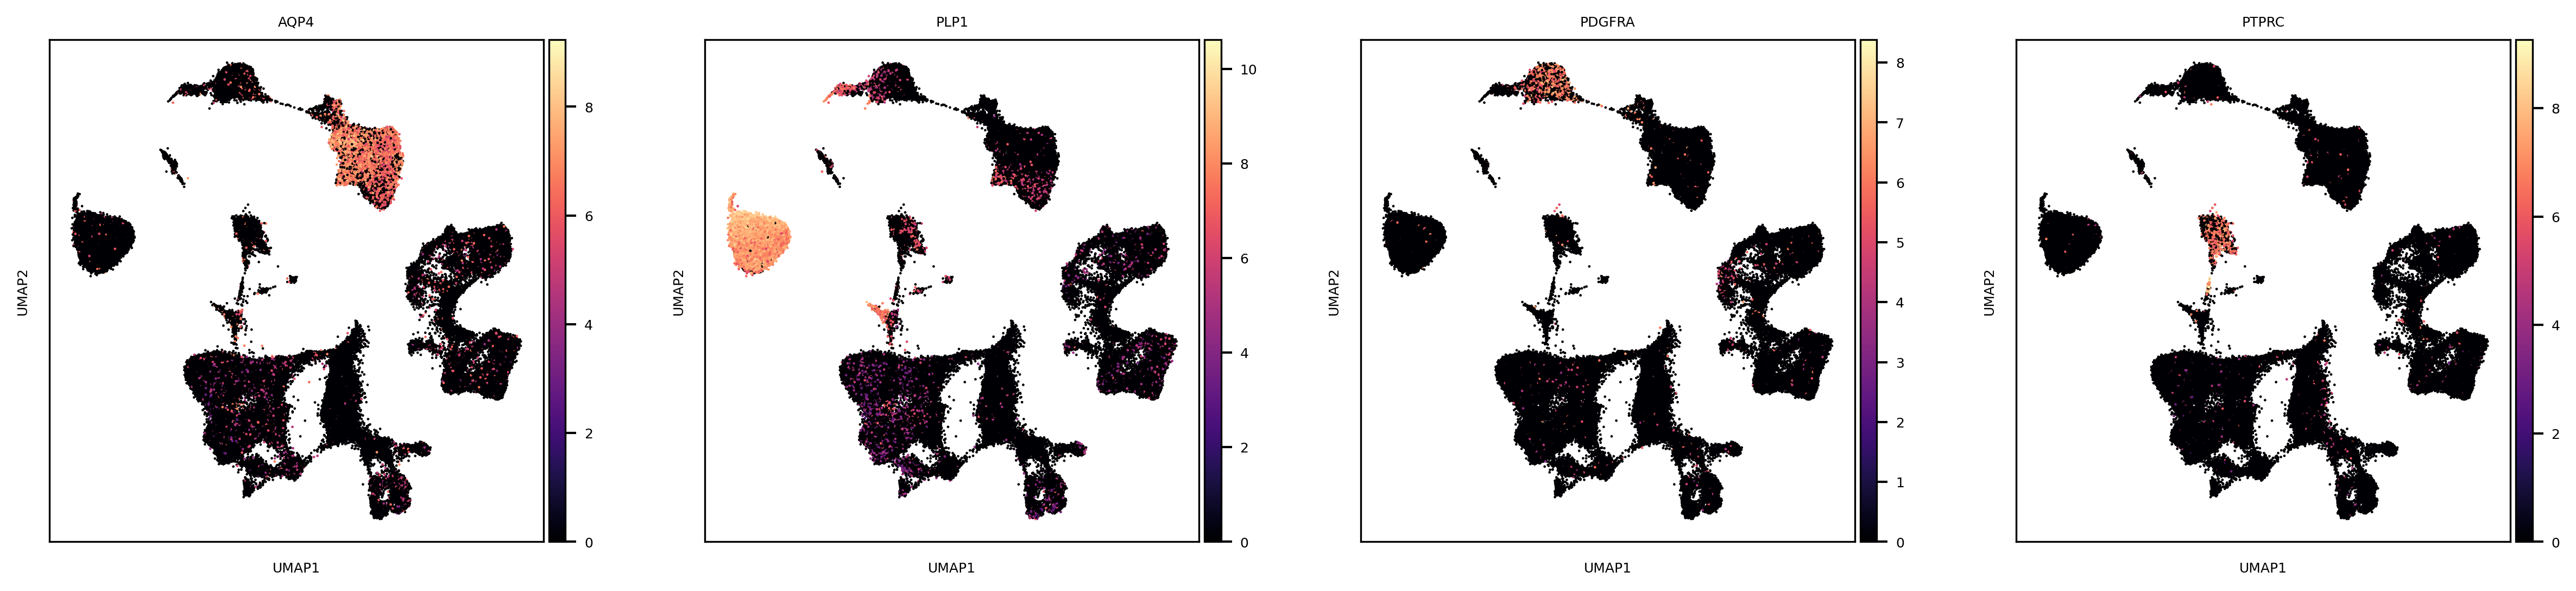

In [33]:
gv_genes = ['AQP4','PLP1','PDGFRA','PTPRC']
plot_save_overlays( gv_genes, 'Glia-Vas_genes')

## **Read in manually annotated cluster data and label leiden clusters**

In [38]:
# read in cluster data
adata.uns['wt_clust_data'] = pd.read_csv( "../data/Whole-Tissue_Cluster-Identification.csv", index_col=['leiden'], dtype=str)
# reformat cluster naming to remove all '/'
adata.uns['wt_clust_data']['major_clust'] = adata.uns['wt_clust_data']['major_clust'].apply( lambda x: x.replace('/','-'))
adata.uns['wt_clust_data']['sub_clust'] = adata.uns['wt_clust_data']['sub_clust'].apply( lambda x: x.replace('/','-'))
adata.uns['wt_clust_data']['dev_clust'] = adata.uns['wt_clust_data']['dev_clust'].apply( lambda x: x.replace('/','-'))
adata.uns['wt_clust_data']['downstream_dev_clusts'] = adata.uns['wt_clust_data']['downstream_dev_clusts'].apply( lambda x: str(x).replace('/','-'))
adata.uns['wt_clust_data'].head()

mat/dev cell_type major_clust     sub_clust     dev_clust  \
leiden                                                             
0          mat   Non-Neu         OPC           OPC           OPC   
1          mat   Non-Neu       Astro  Astro_SLC1A2  Astro_SLC1A2   
2          dev   Non-Neu       Astro   Astro_dev-1     Astro_dev   
3          mat   Non-Neu       Oligo     Oligo_mat         Oligo   
4          mat   Non-Neu       Oligo       Oligo-1         Oligo   

             downstream_dev_clusts  
leiden                              
0                          OPC_dev  
1       Astro_SLC1A2_dev,Astro_dev  
2                             root  
3                    Oligo,OPC_MBP  
4                    Oligo,OPC_MBP

### Assign cluster data to nuclei


In [39]:
# to merge on index have to change to str to match .obs['leiden'] dtype 
adata.uns['wt_clust_data'].index = adata.uns['wt_clust_data'].index.map(str)
# list clusters of interest
coi = ['mat/dev','cell_type','major_clust','sub_clust','dev_clust','downstream_dev_clusts']
# populate observations with cluster data
adata.obs = adata.obs.join( adata.uns['wt_clust_data'][coi], on="leiden")

adata.obs.head()

batch     RL#  age chem concat_id  \
AAACCTGAGAGTCGGT-RL1612_34d_v2  RL1612_34d_v2  RL1612  34d   v2         0   
AAACCTGAGCCGCCTA-RL1612_34d_v2  RL1612_34d_v2  RL1612  34d   v2         0   
AAACCTGAGTCGAGTG-RL1612_34d_v2  RL1612_34d_v2  RL1612  34d   v2         0   
AAACCTGAGTGAACAT-RL1612_34d_v2  RL1612_34d_v2  RL1612  34d   v2         0   
AAACCTGCAAGGACTG-RL1612_34d_v2  RL1612_34d_v2  RL1612  34d   v2         0   

                                numerical_age  stage_id Sex Race  PMI  ...  \
AAACCTGAGAGTCGGT-RL1612_34d_v2       0.093151  Neonatal   M   AA    5  ...   
AAACCTGAGCCGCCTA-RL1612_34d_v2       0.093151  Neonatal   M   AA    5  ...   
AAACCTGAGTCGAGTG-RL1612_34d_v2       0.093151  Neonatal   M   AA    5  ...   
AAACCTGAGTGAACAT-RL1612_34d_v2       0.093151  Neonatal   M   AA    5  ...   
AAACCTGCAAGGACTG-RL1612_34d_v2       0.093151  Neonatal   M   AA    5  ...   

                               percent_mito percent_ribo n_counts leiden  \
AAACCTGAGAGTCGGT-RL1612_34d_v2     0.005910     0.008087   3079.0     10   
AAACCTGAGCCGCCTA-RL1612_34d_v2     0.004802     0.008526   9597.0     15   
AAACCTGAGTCGAGTG-RL1612_34d_v2     0.009107     0.007372   2186.0     23   
AAACCTGAGTGAACAT-RL1612_34d_v2     0.001033     0.006973   7428.0     15   
AAACCTGCAAGGACTG-RL1612_34d_v2     0.009174     0.003823   1122.0     19   

                               mat/dev cell_type  major_clust  \
AAACCTGAGAGTCGGT-RL1612_34d_v2     dev        PN      L4_RORB   
AAACCTGAGCCGCCTA-RL1612_34d_v2     dev        PN    L2-3_CUX2   
AAACCTGAGTCGAGTG-RL1612_34d_v2      IN        IN           IN   
AAACCTGAGTGAACAT-RL1612_34d_v2     dev        PN    L2-3_CUX2   
AAACCTGCAAGGACTG-RL1612_34d_v2     dev   Non-Neu        Astro   

                                      sub_clust      dev_clust  \
AAACCTGAGAGTCGGT-RL1612_34d_v2    L4_RORB_dev-2    L4_RORB_dev   
AAACCTGAGCCGCCTA-RL1612_34d_v2  L2-3_CUX2_dev-2  L2-3_CUX2_dev   
AAACCTGAGTCGAGTG-RL1612_34d_v2               IN             IN   
AAACCTGAGTGAACAT-RL1612_34d_v2  L2-3_CUX2_dev-2  L2-3_CUX2_dev   
AAACCTGCAAGGACTG-RL1612_34d_v2      Astro_dev-2      Astro_dev   

                                downstream_dev_clusts  
AAACCTGAGAGTCGGT-RL1612_34d_v2                   root  
AAACCTGAGCCGCCTA-RL1612_34d_v2                   root  
AAACCTGAGTCGAGTG-RL1612_34d_v2                     IN  
AAACCTGAGTGAACAT-RL1612_34d_v2                   root  
AAACCTGCAAGGACTG-RL1612_34d_v2                   root  

[5 rows x 36 columns]

... storing 'leiden' as categorical
... storing 'mat/dev' as categorical
... storing 'cell_type' as categorical
... storing 'major_clust' as categorical
... storing 'sub_clust' as categorical
... storing 'dev_clust' as categorical
... storing 'downstream_dev_clusts' as categorical


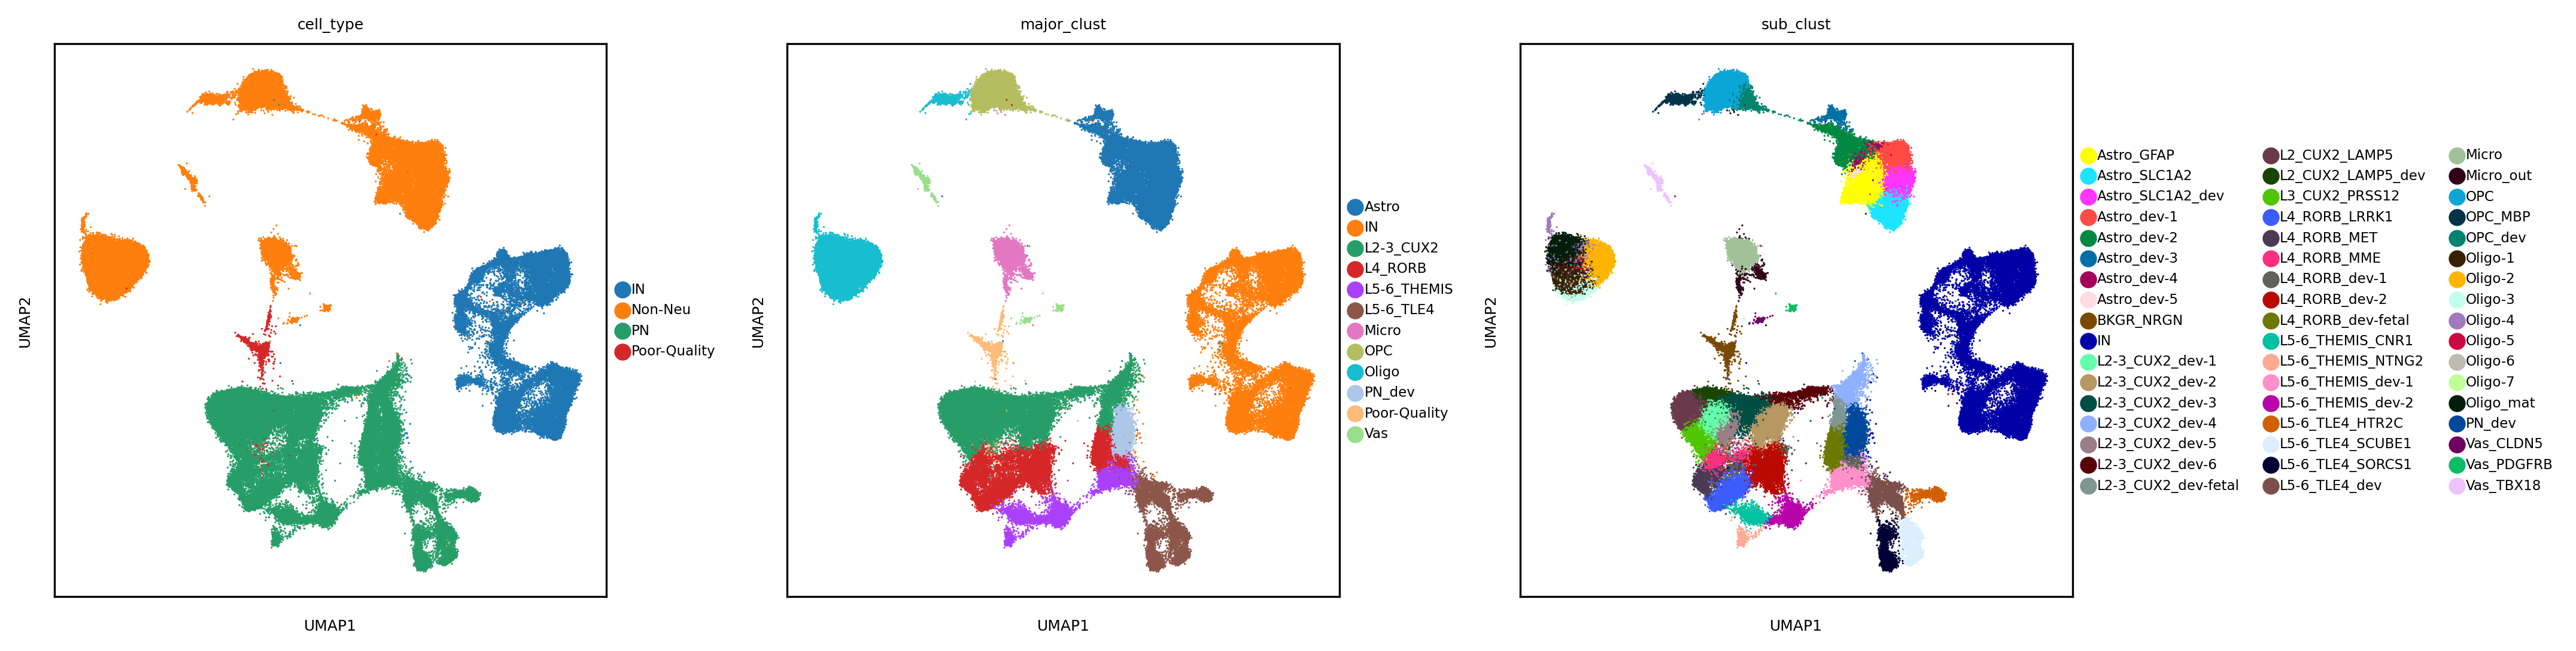

In [40]:
ax = sc.pl.umap( adata, color=['cell_type','major_clust','sub_clust'], size=2.5, sort_order=False, show=False)

In [41]:
adata.write( "../data/post-wt-clustering.h5ad")